## Read Data from Subjects 

In [1]:
import pandas as pd

data =  pd.read_csv('data/subjects/exp_yn.csv')

In [2]:
data.dtypes

Subject       object
Date_Time     object
CH_1_mV      float64
CH_2_mV      float64
Target        object
dtype: object

In [3]:
data[5377:6401].head()

,Subject,Date_Time,CH_1_mV,CH_2_mV,Target
5377,exp_yn,2019-03-04 20:49:10.158599,-8.333654,-0.798579,no
5378,exp_yn,2019-03-04 20:49:10.158801,-8.337501,-0.795478,no
5379,exp_yn,2019-03-04 20:49:10.158899,-8.332068,-0.798483,no
5380,exp_yn,2019-03-04 20:49:10.158989,-8.336563,-0.798963,no
5381,exp_yn,2019-03-04 20:49:10.231059,-8.318004,-0.794804,no


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.plot('CH_2_mV', data = data)
plt.show()

<Figure size 640x480 with 1 Axes>

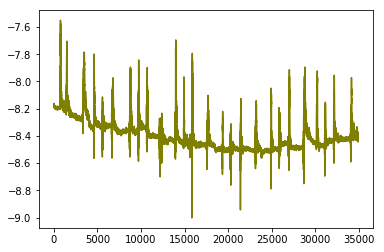

In [5]:
plt.plot('CH_1_mV', data= data,  color='olive')
plt.show()

In [6]:
print('max:', data['CH_1_mV'].max())
print('min:', data['CH_1_mV'].min())

max: -7.550100789479508
min: -9.002918879539036


## Determine frequencies 

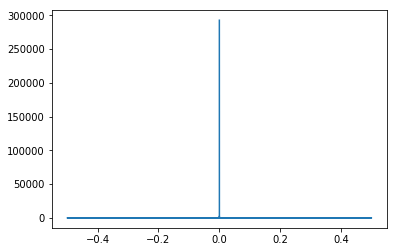

In [7]:
import numpy.fft as fft

# Choose signal 
orig_signal = data['CH_1_mV']

#calculate fourier transform 
spectrum = fft.fft(orig_signal)

#plot the magnitudes 
freq = fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))
plt.show()

In [8]:
max_y = max(abs(spectrum))  # Find the maximum y value
min_y = min(abs(spectrum))
max_x = freq[list(abs(spectrum)).index(max_y)]  # Find the x value corresponding to the maximum y value
min_x = freq[list(abs(spectrum)).index(min_y)]  # Find the x value corresponding to the maximum y value

print('max:', max_x)
print('min:', min_x)

max: 0.0
min: 0.4689943574026867


## Envelope of Signal 

In [9]:
def getEnvelope (inputSignal):

    # Taking the absolute value

    absoluteSignal = []
    for sample in inputSignal:
        absoluteSignal.append (abs (sample))

    # Peak detection

    intervalLength = 100# Experiment with this number, it depends on your sample frequency and highest "whistle" frequency
    outputSignal = []

    for baseIndex in range (intervalLength, len (absoluteSignal)):
        maximum = 0
        for lookbackIndex in range(intervalLength):
            maximum = max (absoluteSignal [baseIndex - lookbackIndex], maximum)
        outputSignal.append (maximum)

    return outputSignal

## Bandpass filter

In [10]:
import numpy as np
import scipy

from scipy import signal

def band_pass(fL, fH, b):
    '''
    :param fL: lower frequency 
    :param fH: higher frequency
    :param b: bandwidth
    :return: bandpass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1# making odd
    n = np.arange(N)

    # low-pass filter
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2.))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    # high-pass filter 
    hhpf = np.sinc(2 * fL * (n - (N - 1) / 2.))
    hhpf *= np.blackman(N)
    hhpf = hhpf / np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((N - 1) / 2)] += 1

    h = np.convolve(hlpf, hhpf)
    return h


## High Pass Filter 

In [11]:
def high_pass(fc,b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: high pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    # reverse function
    sinc_func = -sinc_func
    sinc_func[int((N - 1) / 2)] += 1
    return sinc_func


## Low Pass Filter 

In [12]:
def low_pass(fc, b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: low pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return sinc_func


## CWT Features 

### Original Singals

In [13]:
# deterime value ranges for targets 
import more_itertools as mit

not_relax = data[data['Target'] != 'relax'].index.tolist()
groups = [list(group) for group in mit.consecutive_groups(not_relax)]

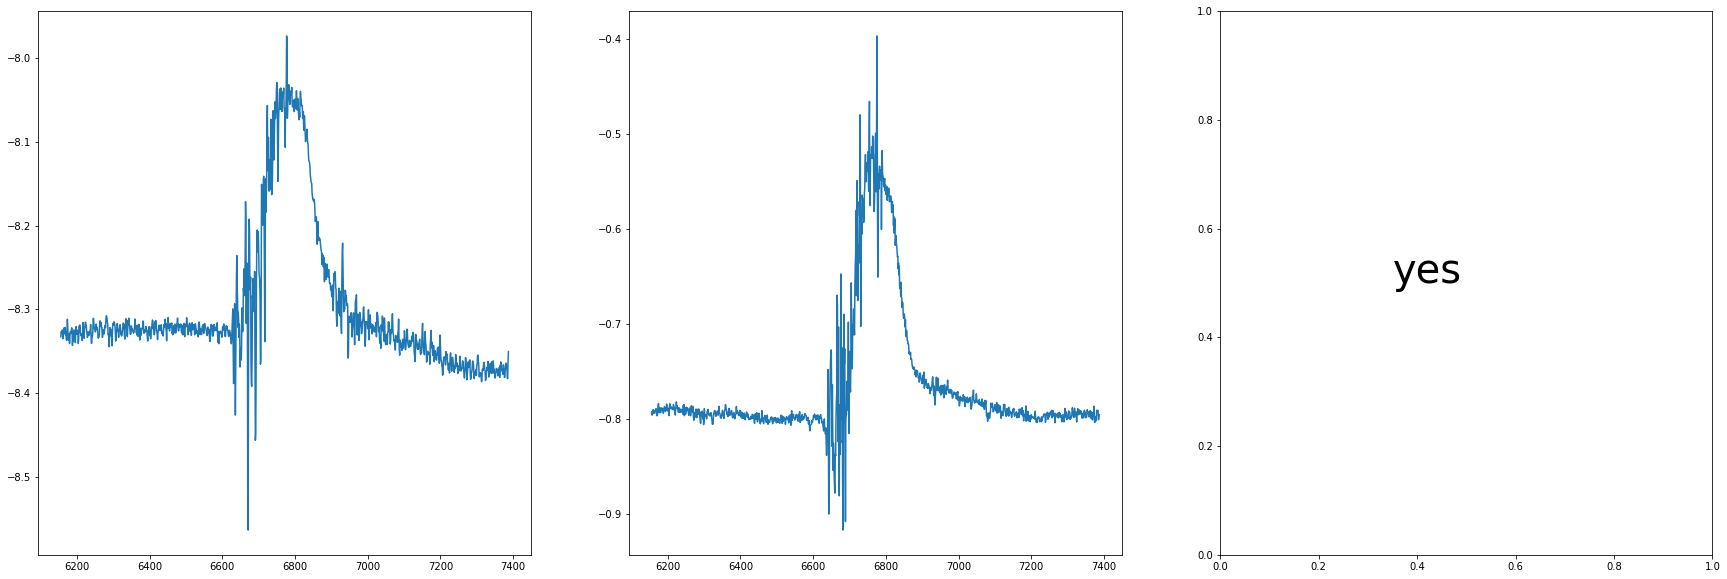

In [14]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.plot(data['CH_1_mV'][min(groups[4]):max(groups[4])])
                      
plt.subplot(1,3,2)
plt.plot(data['CH_2_mV'][min(groups[4]):max(groups[4])])

plt.subplot(1,3,3)
plt.text(0.35, 0.5, data.iloc[min(groups[4]) + 10]['Target'] , dict(size=40))

                         
plt.show()  

## Filterd Signals 

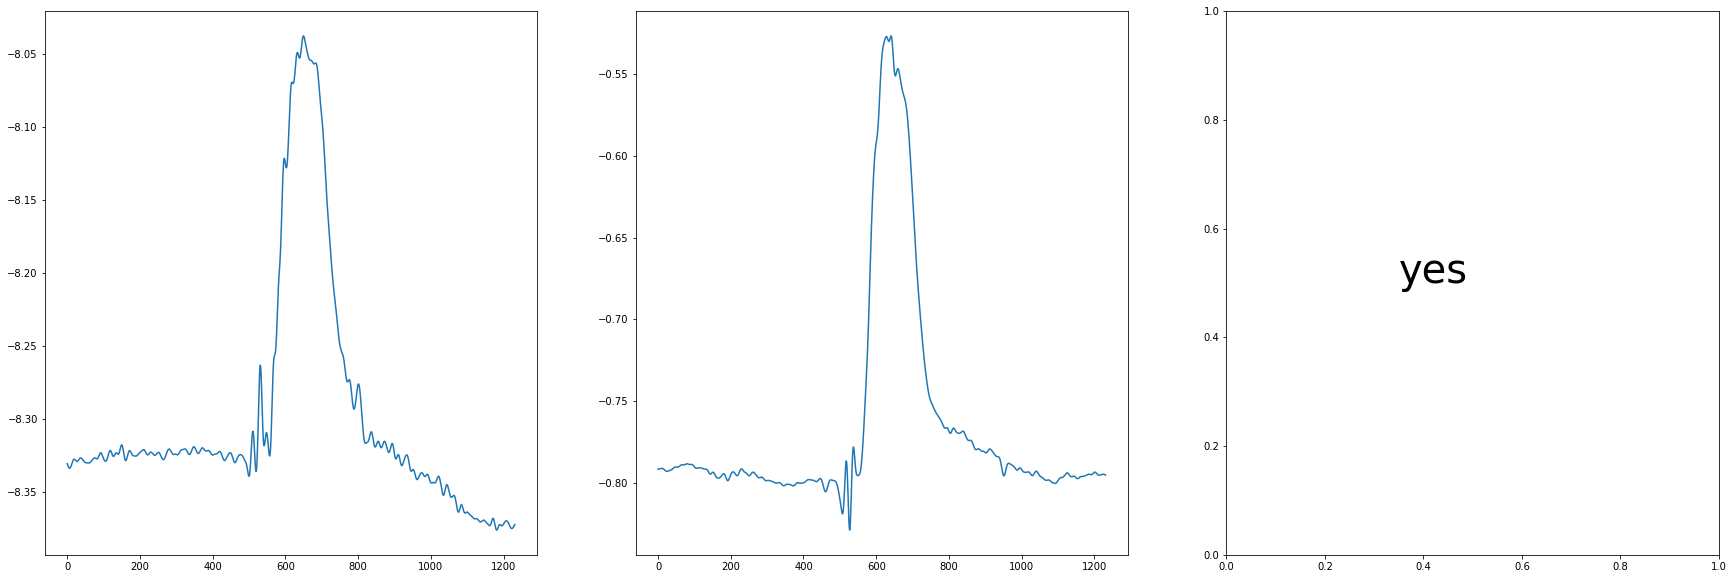

In [15]:
# use the plot function
lp_filter = low_pass(0.05,0.08)

plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
ch1 = np.convolve(data['CH_1_mV'], lp_filter)
plt.plot(ch1[min(groups[4]):max(groups[4])])

plt.subplot(1,3,2)
ch2 = np.convolve(data['CH_2_mV'], lp_filter)
plt.plot(ch2[min(groups[4]):max(groups[4])])

plt.subplot(1,3,3)
plt.text(0.35, 0.5, data.iloc[min(groups[4]) + 10]['Target'] , dict(size=40))

plt.show() 

## Create Continous Wavelet Transform 

In [16]:
 def create_plots(rows,data):
    '''
    :param rows: rows from ranges of taget values 
    :param data: data frame to use
    :return: plot of sigals, cwt and target response 
    '''
    widths = np.arange(1,50)
    
    plt.figure(figsize=(25,5))

    plt.subplot(1,5,1)
    plt.plot(ch1[min(rows):max(rows)])

    plt.subplot(1,5,2)
    cwtmatr = signal.cwt(ch1[min(rows):max(rows)], signal.ricker, widths)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='hsv', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

    plt.subplot(1,5,3)
    plt.plot(ch2[min(rows):max(rows)])

    plt.subplot(1,5,4)
    cwtmatr = signal.cwt(ch2[min(rows):max(rows)], signal.ricker, widths)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='hsv', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    
    plt.subplot(1,5,5)
    plt.text(0.35, 0.5, data.iloc[min(rows) + 10]['Target'] , dict(size=30))
    
    plt.show()

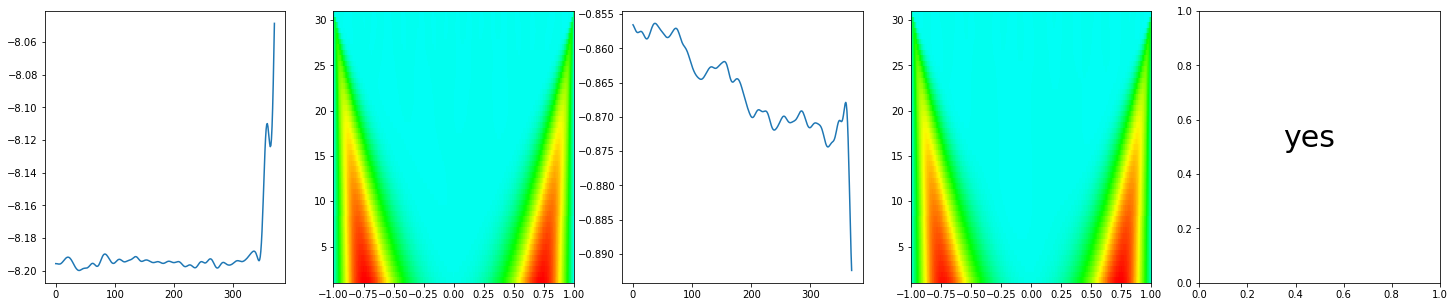

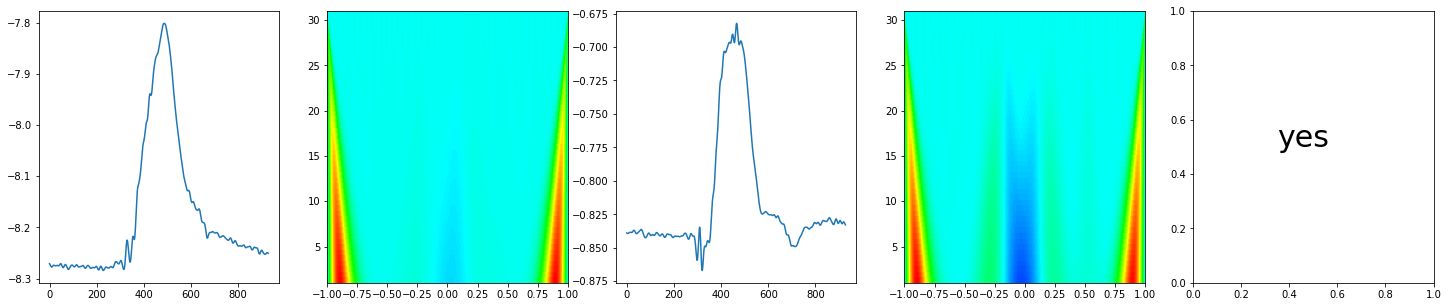

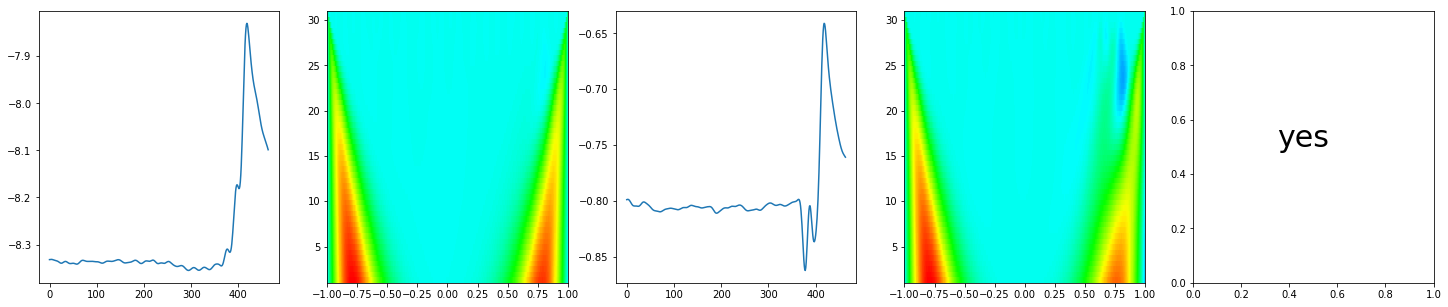

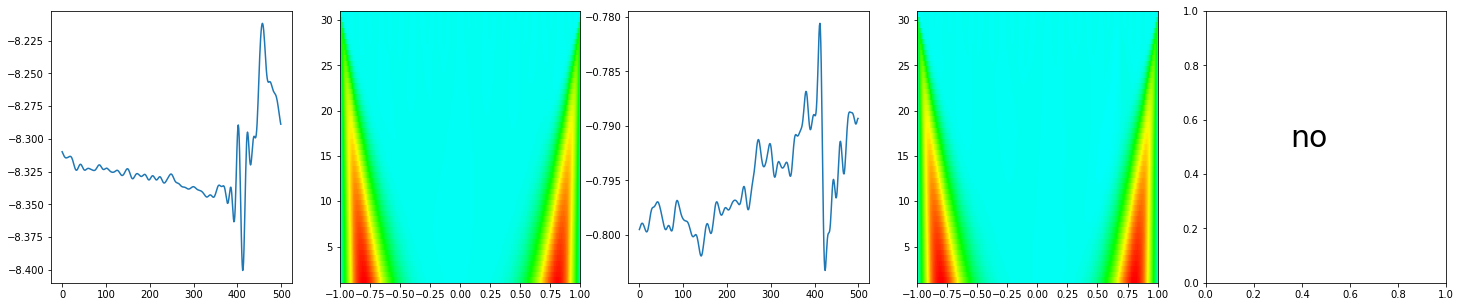

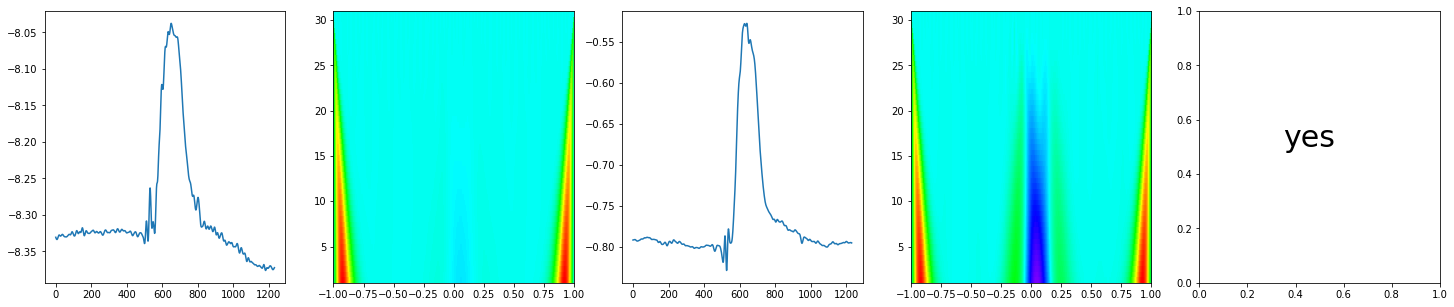

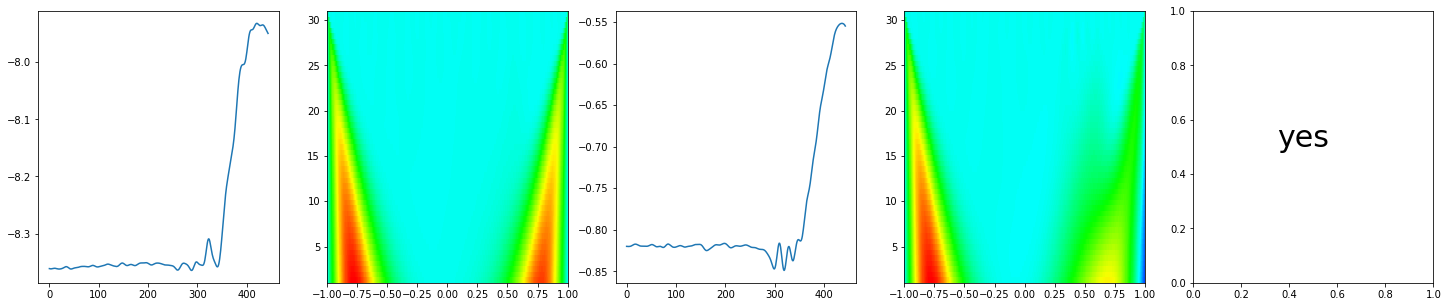

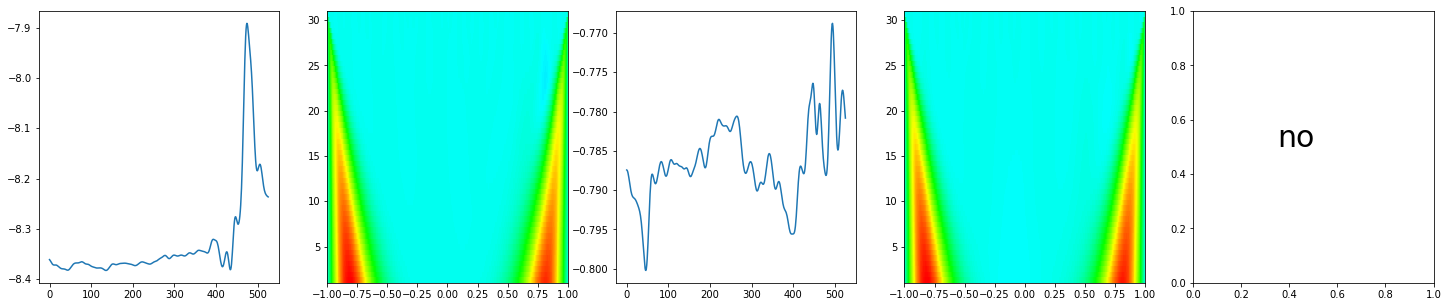

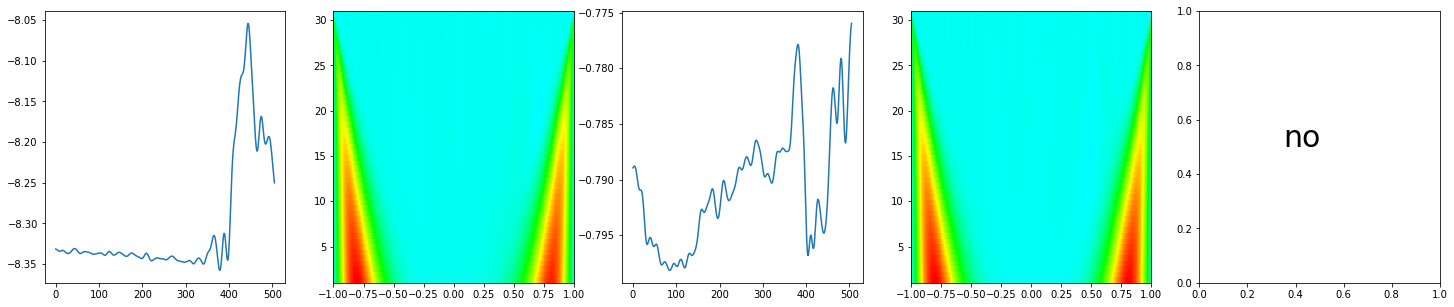

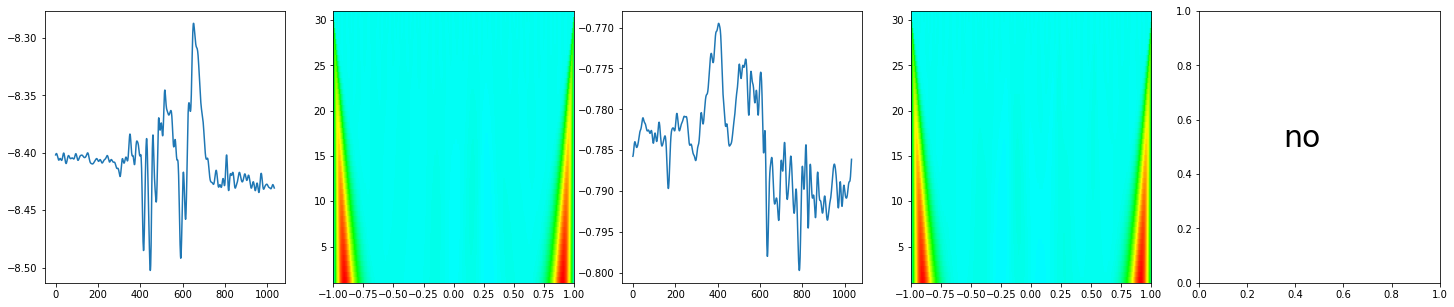

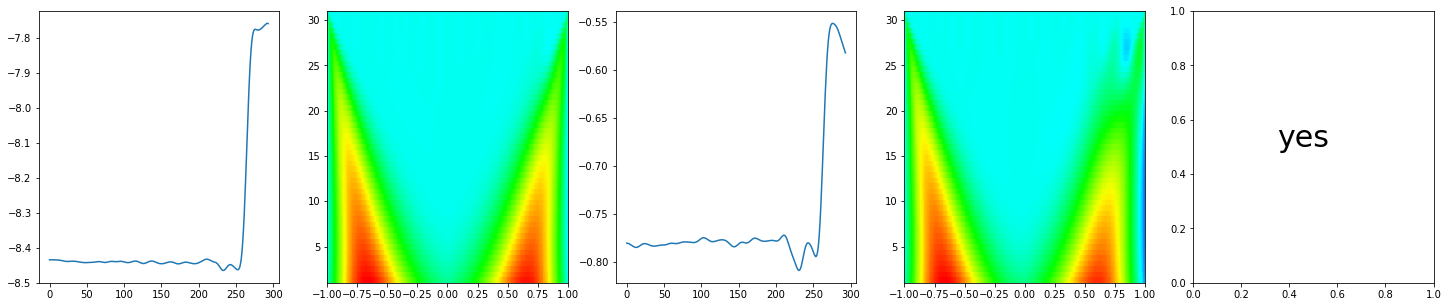

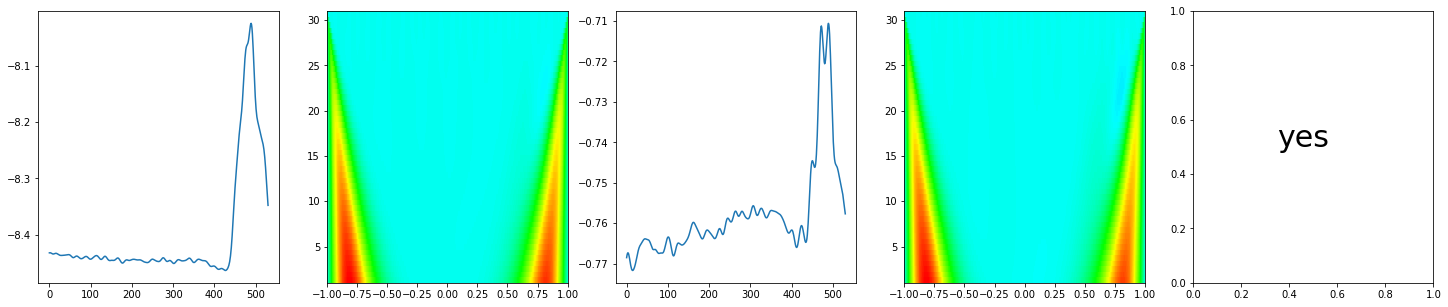

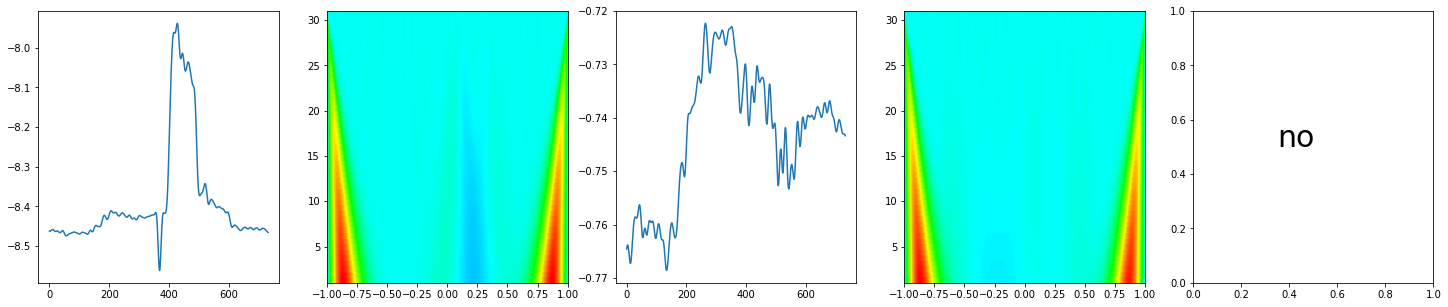

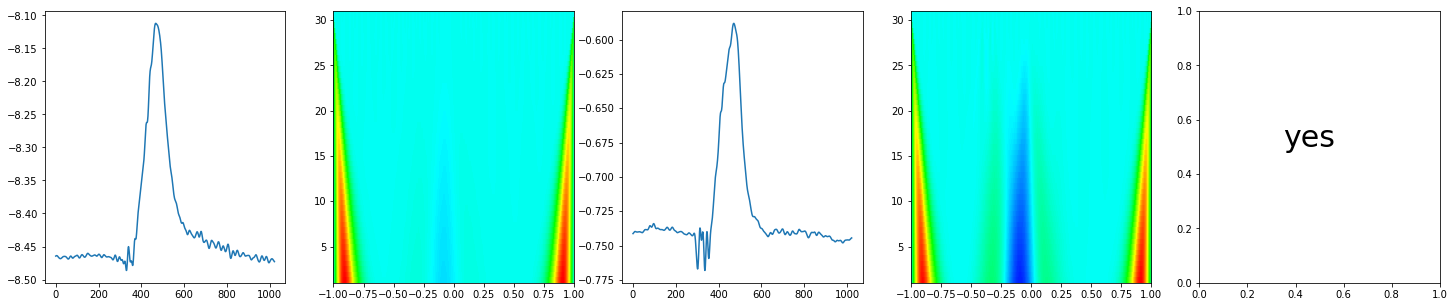

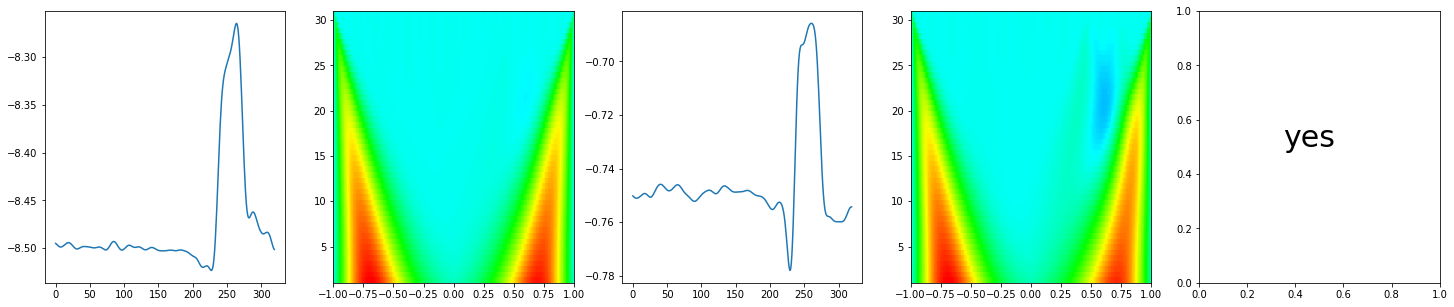

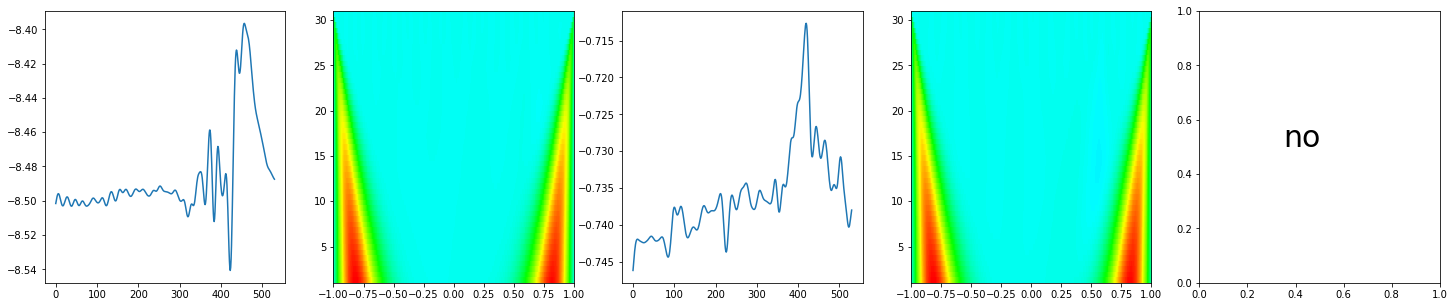

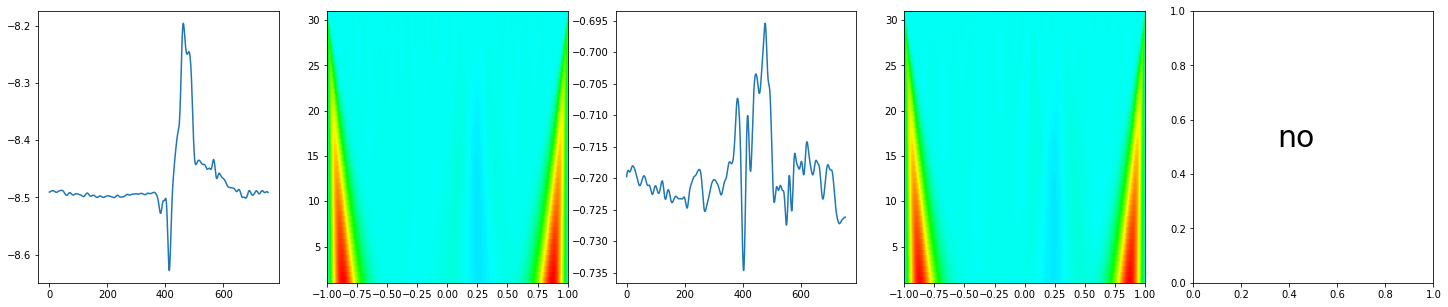

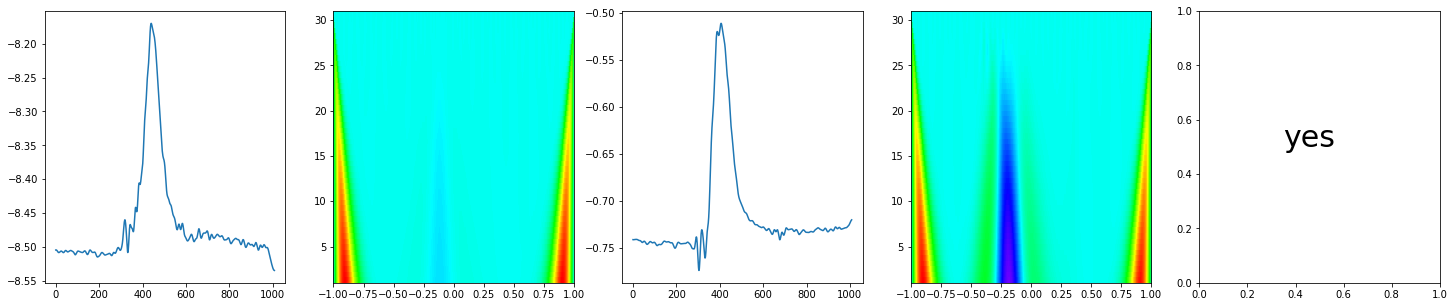

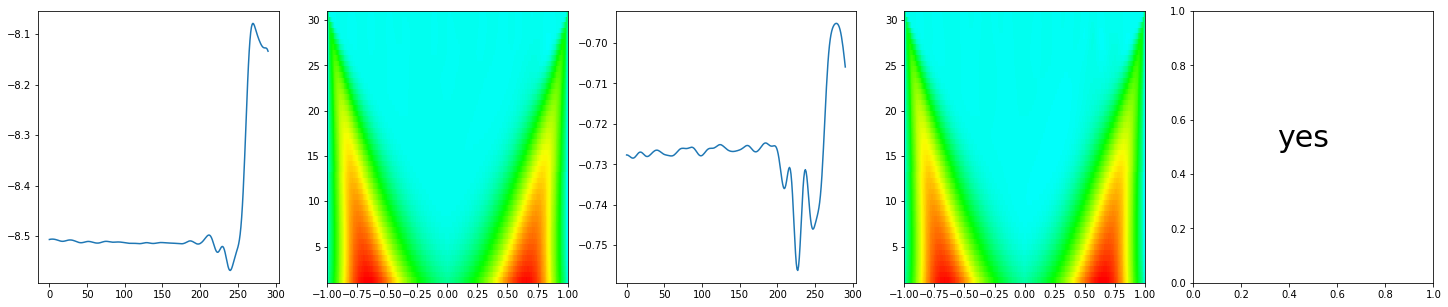

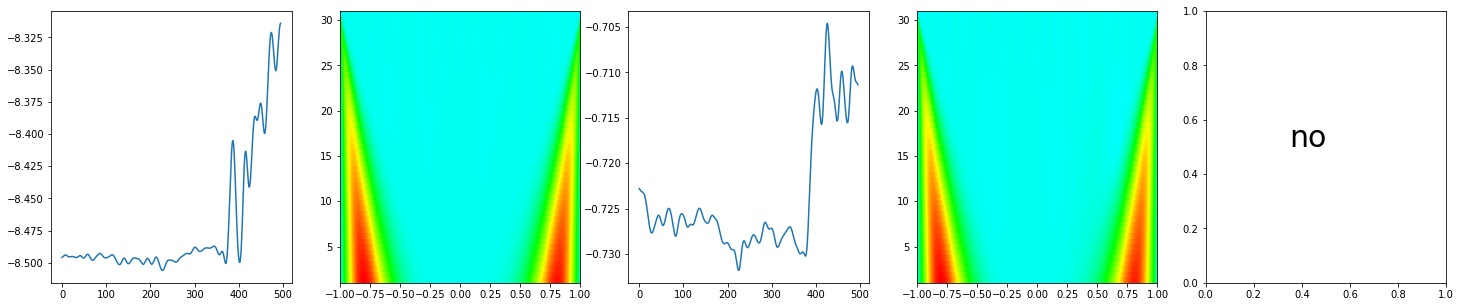

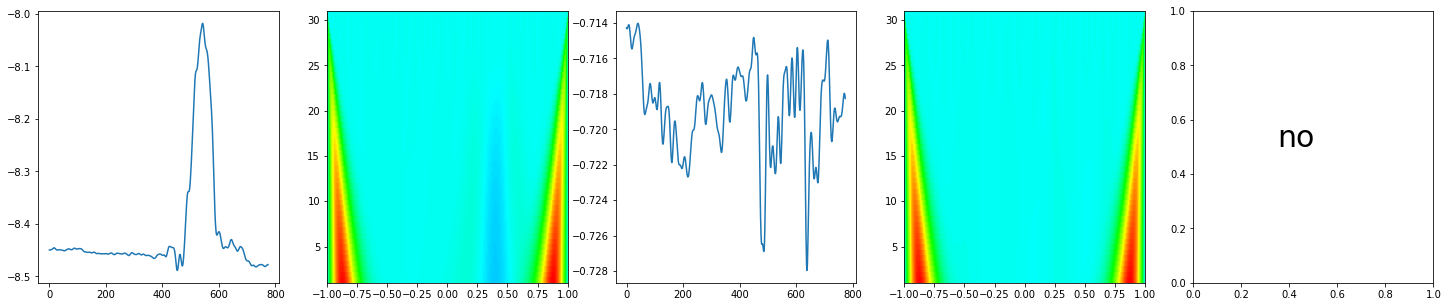

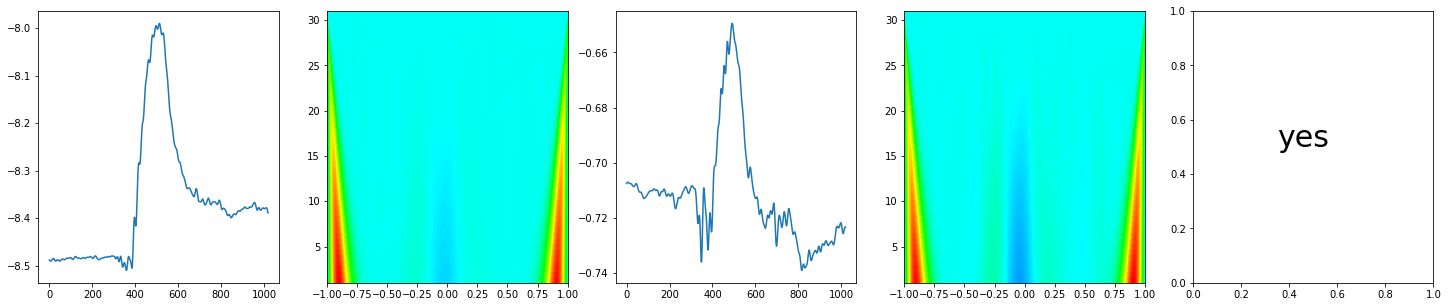

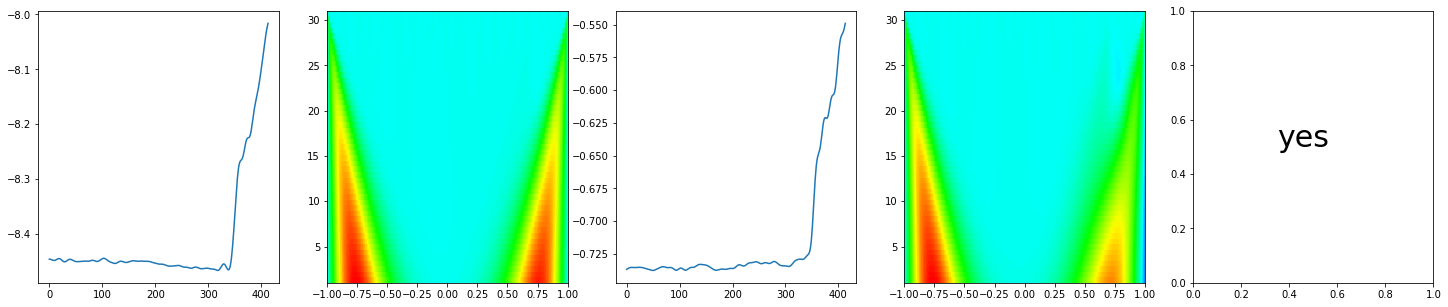

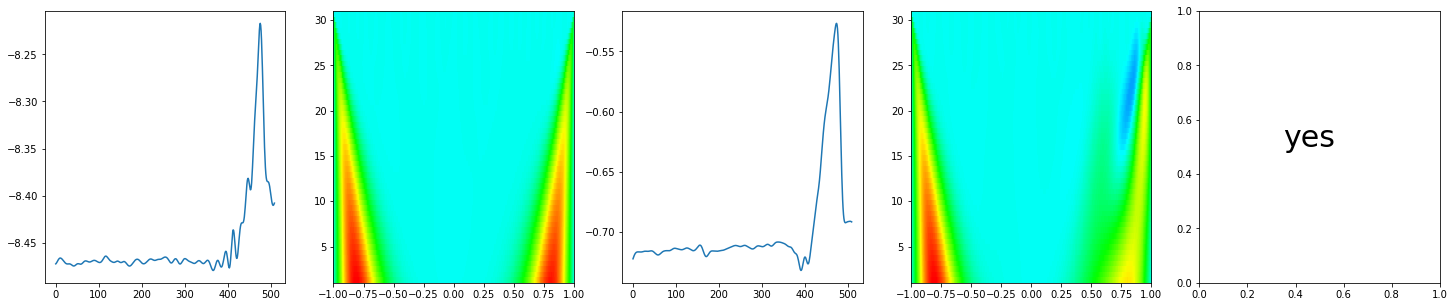

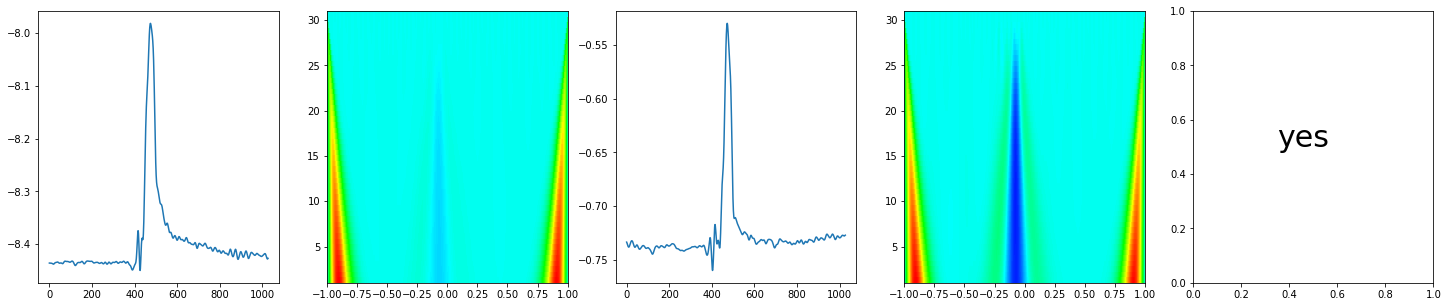

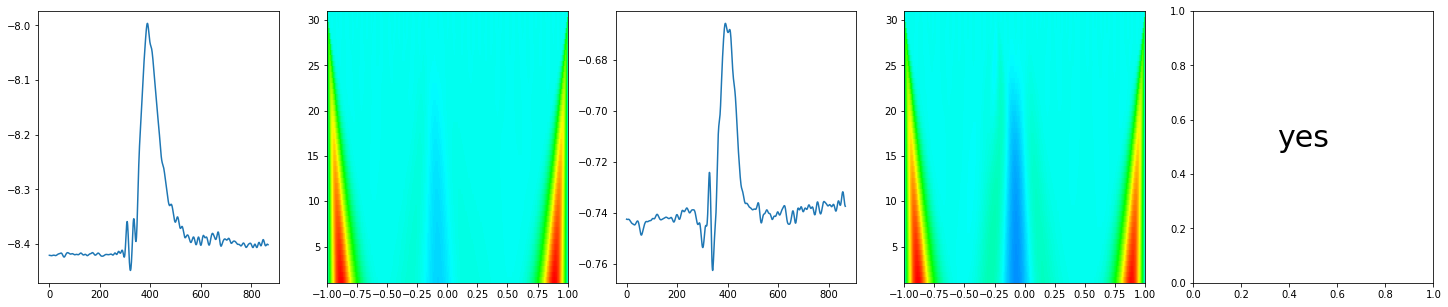

In [17]:
# Plot Results 
for rows in groups:
    create_plots(rows,data)

## Next Steps 
* Determine better options for CWT Figures 
* Get more Data 
* Implement multi-input CNN

![title](images/multi-input-multi-output-graph.png 'multi-input keras' )